# Compare likelihoods using different theory objects

In this notebook we compare the old theory (lya_theory) that uses compressed likelihood parameters ($\Delta_p^2$, $n_p$), with the new theory (full_theory) that uses CMB parameters ($A_s$, $n_s$).

We start by comparing emulator calls, P1D predictions and likelihood evaluations for the fiducial model. Here we want to get exactly the same numbers, almost down to machine precision.

We then redo the exercise for a test cosmology, where we only change primordial power spectrum parameters.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
# our modules
import data_MPGADGET
import p1d_arxiv
import gp_emulator
import likelihood
import likelihood_parameter
import lya_theory
import full_theory
import camb_cosmo
import CAMB_model
import linear_power_model

In [2]:
# specify verbosity for all objects (except emulator)
verbose=False

### Setup mock data, from one of simulations in the suite

In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
# specify simulation to use to generate synthetic data
test_sim_num=15
data=data_MPGADGET.P1D_MPGADGET(sim_number=test_sim_num,basedir=basedir,skewers_label=skewers_label,data_cov_factor=1)

### Setup archive of P1D measurements from simulations and train the emulator

In [4]:
# specify redshift range
z_max=4
# specify pivot point to be used in emulator (slow)
emu_kp_Mpc=None
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_num,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label,
                            kp_Mpc=emu_kp_Mpc)

In [5]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 270 points
Optimised


### Setup fiducial cosmology

In [6]:
# Fiducial cosmology 
cosmo_fid=camb_cosmo.get_cosmology()
camb_cosmo.print_info(cosmo_fid)
# compute linP parameters
linP_fid=linear_power_model.LinearPowerModel(cosmo=cosmo_fid)
old_like_params_fid=linP_fid.get_likelihood_parameters()
print('old likelihood parameters for fiducial cosmology')
for par in old_like_params_fid:
    print(par.info_str())

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00
old likelihood parameters for fiducial cosmology
g_star = 0.9677508579459803
f_star = 0.9813690142874731
Delta2_star = 0.36031521437759373
n_star = -2.299480437811641
alpha_star = -0.21635743106849248


In [7]:
# setup camb model (needed in full_theory)
camb_model_fid=CAMB_model.CAMBModel(zs=data.z,cosmo=cosmo_fid)
new_like_params_fid=camb_model_fid.get_likelihood_parameters()
print('new likelihood parameters for fiducial cosmology')
for par in new_like_params_fid:
    print(par.info_str())

new likelihood parameters for fiducial cosmology
ombh2 = 0.022
omch2 = 0.12
As = 2.1e-09
ns = 0.965
H0 = 67.0
mnu = 0.0


### Setup and compare theory objects for fiducial cosmology

Start by setting up an old theory object, that uses only compressed linP parameters

In [8]:
old_theory=lya_theory.LyaTheory(zs=data.z,emulator=emu,cosmo_fid=cosmo_fid,verbose=verbose)
old_emu_calls_fid=old_theory.get_emulator_calls()

In [9]:
# we want to study also cases where we ignore some of the parameters (although here we expect equal results)
cull_params=['f_star','g_star','alpha_star']
culled_like_params_fid = [par for par in old_like_params_fid if par.name not in cull_params]
for par in culled_like_params_fid:
    print(par.info_str())
culled_emu_calls_fid=old_theory.get_emulator_calls(like_params=culled_like_params_fid)

Delta2_star = 0.36031521437759373
n_star = -2.299480437811641


Setup now a new theory object, that holds a CAMB object

In [10]:
new_theory=full_theory.FullTheory(zs=data.z,emulator=emu,camb_model_fid=camb_model_fid,verbose=verbose)
new_emu_calls_fid=new_theory.get_emulator_calls(return_M_of_z=False)

In [11]:
print("z=2 emulator calls for old theory = ", old_emu_calls_fid[0])
print("z=2 emulator calls for culled theory = ", culled_emu_calls_fid[0])
print("z=2 emulator calls for new theory = ", new_emu_calls_fid[0])

z=2 emulator calls for old theory =  {'Delta2_p': 0.6363697860232743, 'n_p': -2.302565594059535, 'alpha_p': -0.21495014931891618, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}
z=2 emulator calls for culled theory =  {'Delta2_p': 0.6363697860232743, 'n_p': -2.302565594059535, 'alpha_p': -0.21495014931891618, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}
z=2 emulator calls for new theory =  {'Delta2_p': 0.6363697860232738, 'n_p': -2.302565594059536, 'alpha_p': -0.2149501493189045, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}


## Compare likelihood evaluations for the fiducial cosmology

### Old likelihood using all five parameters

In [12]:
## Set up a likelihood object with the old theory object
#old_free_params=['Delta2_star','n_star']
old_free_params=['Delta2_star','n_star','alpha_star','f_star','g_star']
old_like=likelihood.Likelihood(data=data,theory=old_theory,
                            free_param_names=old_free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [13]:
# get parameter values in cube for fiducial cosmology
old_values_fid=old_like.sampling_point_from_parameters(old_like_params_fid)
# check that parameters inferred from these are same than computed before
for par in old_like.parameters_from_sampling_point(values=old_values_fid):
    print(par.info_str(),',',par.value_in_cube())

Delta2_star = 0.36031521437759373 , 0.7354347625172915
n_star = -2.299480437811641 , 0.5051956218835891
alpha_star = -0.21635743106849248 , 0.4876597175591594
f_star = 0.9813690142874731 , 0.784225357186829
g_star = 0.9677508579459803 , 0.4437714486495072


### Old likelihood using only two parameters (should not make a different, no change in growth / expansion)

In [14]:
## Set up a likelihood object with the old theory object, but now with only 2 key parameters
culled_free_params=['Delta2_star','n_star']
culled_like=likelihood.Likelihood(data=data,theory=old_theory,
                            free_param_names=culled_free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [15]:
# get parameter values in cube for fiducial cosmology
culled_values_fid=culled_like.sampling_point_from_parameters(culled_like_params_fid)
# check that parameters inferred from these are same than computed before
for par in culled_like.parameters_from_sampling_point(values=culled_values_fid):
    print(par.info_str(),',',par.value_in_cube())

Delta2_star = 0.36031521437759373 , 0.7354347625172915
n_star = -2.299480437811641 , 0.5051956218835891


### New likelihood

In [16]:
## Set up a likelihood object with the new theory object
new_free_params=["As","ns"]
new_like=likelihood.Likelihood(data=data,theory=new_theory,
                            free_param_names=new_free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [17]:
# get parameter values in cube for fiducial cosmology in new theory
new_values_fid=new_like.sampling_point_from_parameters(new_like_params_fid)
# check that parameters inferred from these are same than computed before
for par in new_like.parameters_from_sampling_point(values=new_values_fid):
    print(par.info_str(),',',par.value_in_cube())

As = 2.1e-09 , 0.5500000000000002
ns = 0.965 , 0.4333333333333329


### Compare chi2 for fiducial model

In [18]:
old_chi2_fid=old_like.get_chi2(values=old_values_fid)
culled_chi2_fid=culled_like.get_chi2(values=culled_values_fid)
new_chi2_fid=new_like.get_chi2(values=new_values_fid)

In [19]:
print('old chi2 for fiducial theory =',old_chi2_fid)
print('culled chi2 for fiducial theory =',culled_chi2_fid)
print('new chi2 for fiducial theory =',new_chi2_fid)

old chi2 for fiducial theory = 839.8906042866683
culled chi2 for fiducial theory = 839.8906042866683
new chi2 for fiducial theory = 839.8906040834989


### Compare log_like for fiducial model (including det C)

In [20]:
old_loglike_fid=old_like.get_log_like(values=old_values_fid,ignore_log_det_cov=False)
culled_loglike_fid=culled_like.get_log_like(values=culled_values_fid,ignore_log_det_cov=False)
new_loglike_fid=new_like.get_log_like(values=new_values_fid,ignore_log_det_cov=False)

In [21]:
print('old log like for fiducial theory =',old_loglike_fid)
print('culled log like for fiducial theory =',culled_loglike_fid)
print('new log like for fiducial theory =',new_loglike_fid)

old log like for fiducial theory = -452.23174878679004
culled log like for fiducial theory = -452.23174878679004
new log like for fiducial theory = -452.231748685195


### Compare log_posterior for fiducial model (including prior)

In [22]:
old_logprob_fid=old_like.log_prob(values=old_values_fid)
culled_logprob_fid=culled_like.log_prob(values=culled_values_fid)
new_logprob_fid=new_like.log_prob(values=new_values_fid)

In [23]:
print('old log prob for fiducial theory =',old_logprob_fid)
print('culled log prob for fiducial theory =',culled_logprob_fid)
print('new log prob for fiducial theory =',new_logprob_fid)

old log prob for fiducial theory = -452.23174878679004
culled log prob for fiducial theory = -452.23174878679004
new log prob for fiducial theory = -452.231748685195


### P1D predictions from the different theories (fiducial cosmology)

In [24]:
zs=data.z
k_kms=np.logspace(np.log10(min(data.k)),np.log10(max(data.k)),500)
old_p1d_fid=old_like.get_p1d_kms(k_kms=k_kms,values=old_values_fid,return_covar=False)
culled_p1d_fid=culled_like.get_p1d_kms(k_kms=k_kms,values=culled_values_fid,return_covar=False)
new_p1d_fid=new_like.get_p1d_kms(k_kms=k_kms,values=new_values_fid,return_covar=False)

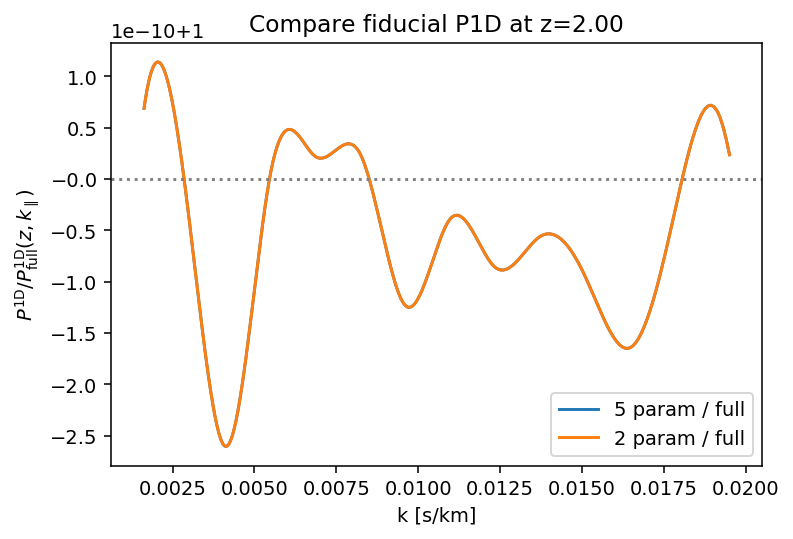

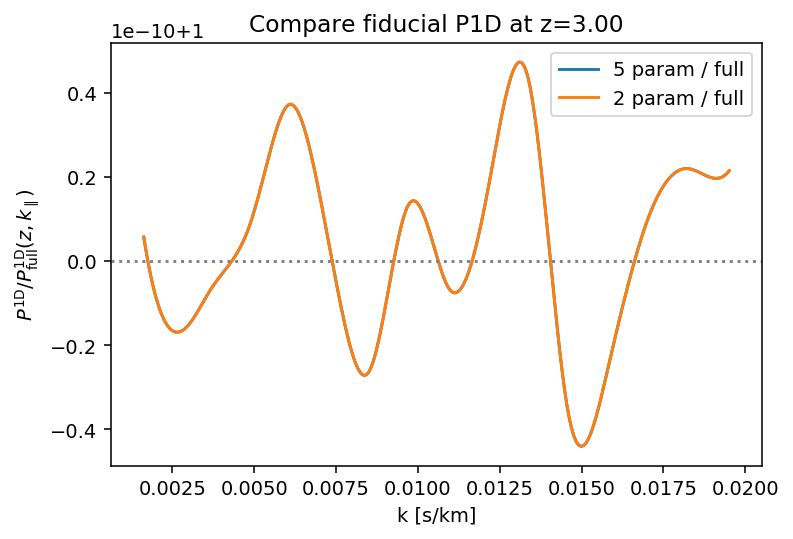

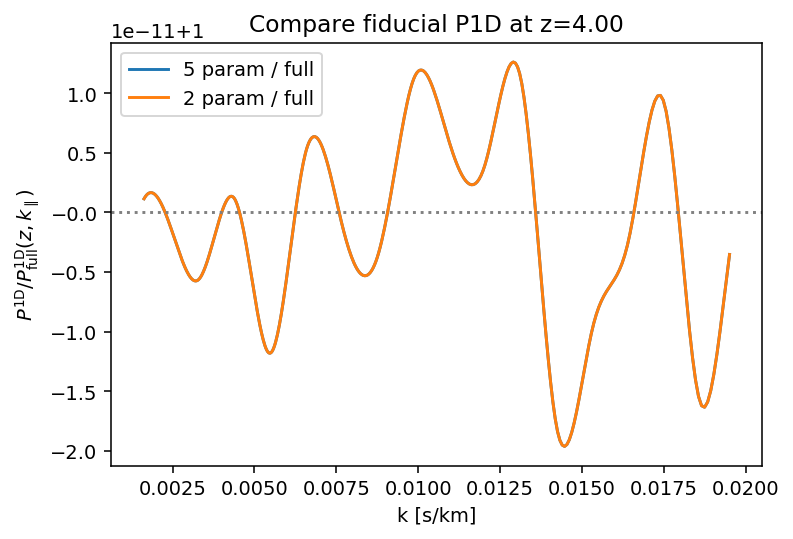

In [25]:
for iz in range(0,len(zs),4):
    z=zs[iz]
    plt.figure()
    plt.plot(k_kms,old_p1d_fid[iz]/new_p1d_fid[iz],label='5 param / full')
    plt.plot(k_kms,culled_p1d_fid[iz]/new_p1d_fid[iz],label='2 param / full')
    plt.legend()
    plt.xlabel('k [s/km]')
    plt.ylabel(r'$P^{\rm 1D} / P^{\rm 1D}_{\rm full} (z,k_\parallel)$')
    plt.xlim(min(k_kms)-0.001,max(k_kms)+0.001)
    plt.axhline(y=1,ls=':',color='gray')
    plt.title('Compare fiducial P1D at z={:.2f}'.format(z))

### We get exactly the same predictions and likelihoods when calling the fiducial cosmology!

# Compare now theory objects when using a test cosmology

In [26]:
# Setup test cosmology (varying only primordial power parameters)
cosmo_test=camb_cosmo.get_cosmology(As=1.9e-9,ns=0.92)
camb_cosmo.print_info(cosmo_test)
# compute linP parameters for test cosmology
linP_test=linear_power_model.LinearPowerModel(cosmo=cosmo_test)
old_like_params_test=linP_test.get_likelihood_parameters()
print('old likelihood parameters for test cosmology')
for par in old_like_params_test:
    print(par.info_str())

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 1.9000E-09, n_s = 9.2000E-01, alpha_s = 0.0000E+00
old likelihood parameters for test cosmology
g_star = 0.9677508579459803
f_star = 0.9813690142874728
Delta2_star = 0.28968178037124304
n_star = -2.3444804378116406
alpha_star = -0.21635743106861072


In [27]:
# setup camb model (needed in full_theory) for test cosmology
camb_model_test=CAMB_model.CAMBModel(zs=data.z,cosmo=cosmo_test)
new_like_params_test=camb_model_test.get_likelihood_parameters()
print('new likelihood parameters for test cosmology')
for par in new_like_params_test:
    print(par.info_str())

new likelihood parameters for test cosmology
ombh2 = 0.022
omch2 = 0.12
As = 1.9e-09
ns = 0.92
H0 = 67.0
mnu = 0.0


### Start by comparing emulator calls for the test cosmology

In [28]:
# call the old theory, but using the freshly computed likelihood parameters from the test cosmology
old_emu_calls_test=old_theory.get_emulator_calls(like_params=old_like_params_test)

In [29]:
# we want to study also cases where we ignore some of the parameters (although here we expect equal results)
culled_like_params_test = [par for par in old_like_params_test if par.name not in cull_params]
for par in culled_like_params_test:
    print(par.info_str())
culled_emu_calls_test=old_theory.get_emulator_calls(like_params=culled_like_params_test)

Delta2_star = 0.28968178037124304
n_star = -2.3444804378116406


In [30]:
# call the new theory, but using the freshly computed likelihood parameters for the test cosmology
new_emu_calls_test=new_theory.get_emulator_calls(like_params=new_like_params_test,return_M_of_z=False)

In [31]:
print("z = {} emulator calls from old theory = {}".format(data.z[0],old_emu_calls_test[0]))
print("z = {} emulator calls from culled theory = {}".format(data.z[0],culled_emu_calls_test[0]))
print("z = {} emulator calls from new theory = {}".format(data.z[0],new_emu_calls_test[0]))

z = 2.0 emulator calls from old theory = {'Delta2_p': 0.5112909390607865, 'n_p': -2.347565594059536, 'alpha_p': -0.21495014931903397, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}
z = 2.0 emulator calls from culled theory = {'Delta2_p': 0.5112909390607859, 'n_p': -2.3475655940595357, 'alpha_p': -0.21495014931892392, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}
z = 2.0 emulator calls from new theory = {'Delta2_p': 0.5112909390607824, 'n_p': -2.347565594059536, 'alpha_p': -0.2149501493189045, 'mF': 0.8507256483811173, 'gamma': 1.5534927645653829, 'sigT_Mpc': 0.13078611068417573, 'kF_Mpc': 9.234642271117814}


In [32]:
print("z = {} emulator calls from old theory = {}".format(data.z[-1],old_emu_calls_test[-1]))
print("z = {} emulator calls from culled theory = {}".format(data.z[-1],culled_emu_calls_test[-1]))
print("z = {} emulator calls from new theory = {}".format(data.z[-1],new_emu_calls_test[-1]))

z = 4.0 emulator calls from old theory = {'Delta2_p': 0.18830638390207535, 'n_p': -2.3475658560183867, 'alpha_p': -0.21495115561885567, 'mF': 0.3667549106286143, 'gamma': 1.4366944565860078, 'sigT_Mpc': 0.1124868806234996, 'kF_Mpc': 12.841201989686333}
z = 4.0 emulator calls from culled theory = {'Delta2_p': 0.18830638390207535, 'n_p': -2.3475658560183854, 'alpha_p': -0.2149511556187264, 'mF': 0.3667549106286143, 'gamma': 1.4366944565860078, 'sigT_Mpc': 0.1124868806234996, 'kF_Mpc': 12.841201989686333}
z = 4.0 emulator calls from new theory = {'Delta2_p': 0.18830638390207402, 'n_p': -2.3475658560183863, 'alpha_p': -0.21495115561871142, 'mF': 0.3667549106286143, 'gamma': 1.4366944565860078, 'sigT_Mpc': 0.1124868806234996, 'kF_Mpc': 12.841201989686333}


### Compare now likelihood parameters for the test cosmology

In [33]:
# get parameter values in cube for test cosmology
old_values_test=old_like.sampling_point_from_parameters(old_like_params_test)
# check that parameters inferred from these are same than computed before
for par in old_like.parameters_from_sampling_point(values=old_values_test):
    print(par.info_str(),',',par.value_in_cube())

Delta2_star = 0.28968178037124304 , 0.26454520247495356
n_star = -2.3444804378116406 , 0.05519562188359468
alpha_star = -0.21635743106861072 , 0.48765971755808446
f_star = 0.9813690142874728 , 0.7842253571868206
g_star = 0.9677508579459803 , 0.4437714486495072


In [34]:
# get parameter values in cube for test cosmology
culled_values_test=culled_like.sampling_point_from_parameters(culled_like_params_test)
# check that parameters inferred from these are same than computed before
for par in culled_like.parameters_from_sampling_point(values=culled_values_test):
    print(par.info_str(),',',par.value_in_cube())

Delta2_star = 0.28968178037124304 , 0.26454520247495356
n_star = -2.3444804378116406 , 0.05519562188359468


In [35]:
# get parameter values in cube for test cosmology
new_values_test=new_like.sampling_point_from_parameters(new_like_params_test)
# check that parameters inferred from these are same than computed before
for par in new_like.parameters_from_sampling_point(values=new_values_test):
    print(par.info_str(),',',par.value_in_cube())

As = 1.9e-09 , 0.45000000000000007
ns = 0.92 , 0.13333333333333344


### Compare chi2 for test cosmology

In [36]:
old_chi2_test=old_like.get_chi2(values=old_values_test)
culled_chi2_test=culled_like.get_chi2(values=culled_values_test)
new_chi2_test=new_like.get_chi2(values=new_values_test)

In [37]:
print('old chi2 for test theory =',old_chi2_test)
print('culled chi2 for test theory =',culled_chi2_test)
print('new chi2 for test theory =',new_chi2_test)

old chi2 for test theory = 159.08855221363754
culled chi2 for test theory = 159.08855221766572
new chi2 for test theory = 159.08855222497704


### Compare log_like for test cosmology (including det C)

In [38]:
old_loglike_test=old_like.get_log_like(values=old_values_test,ignore_log_det_cov=False)
culled_loglike_test=culled_like.get_log_like(values=culled_values_test,ignore_log_det_cov=False)
new_loglike_test=new_like.get_log_like(values=new_values_test,ignore_log_det_cov=False)

In [39]:
print('old log like for test cosmology =',old_loglike_test)
print('culled log like for test cosmology =',culled_loglike_test)
print('new log like for test cosmology =',new_loglike_test)

old log like for test cosmology = -125.57428353835951
culled log like for test cosmology = -125.57428354029832
new log like for test cosmology = -125.57428354397251


### Compare log_posterior for test cosmology (including prior)

In [40]:
old_logprob_test=old_like.log_prob(values=old_values_test)
culled_logprob_test=culled_like.log_prob(values=culled_values_test)
new_logprob_test=new_like.log_prob(values=new_values_test)

In [41]:
print('old log prob for test cosmology =',old_logprob_test)
print('culled log prob for test cosmology =',culled_logprob_test)
print('new log prob for test cosmology =',new_logprob_test)

old log prob for test cosmology = -135.00177193295644
culled log prob for test cosmology = -135.00177193489526
new log prob for test cosmology = -127.79650576619473


### P1D predictions from the different theories (test cosmology)

In [42]:
old_p1d_test=old_like.get_p1d_kms(k_kms=k_kms,values=old_values_test,return_covar=False)
culled_p1d_test=culled_like.get_p1d_kms(k_kms=k_kms,values=culled_values_test,return_covar=False)
new_p1d_test=new_like.get_p1d_kms(k_kms=k_kms,values=new_values_test,return_covar=False)

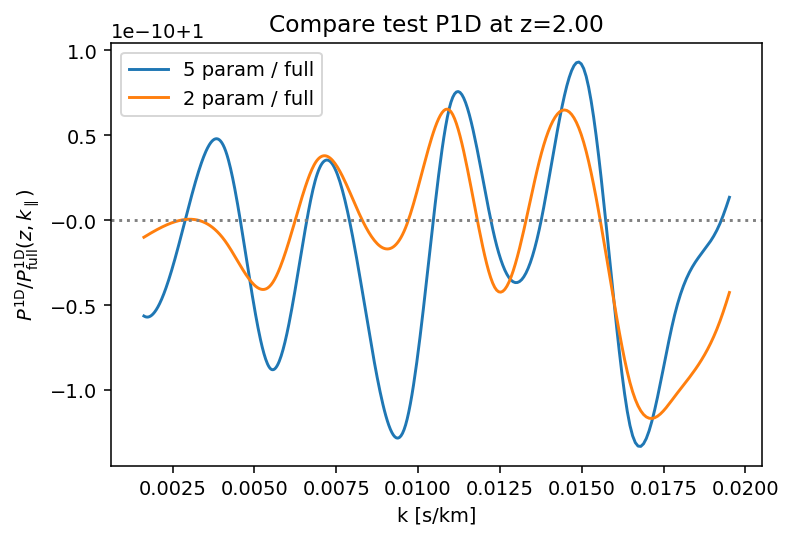

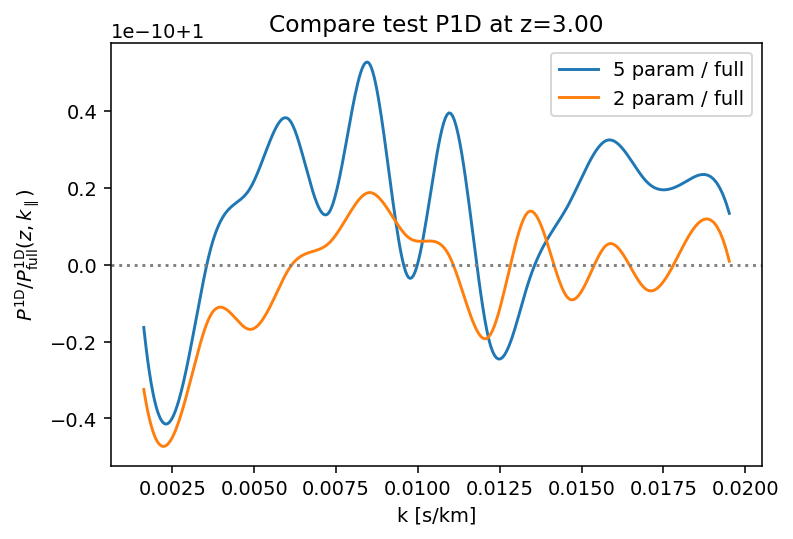

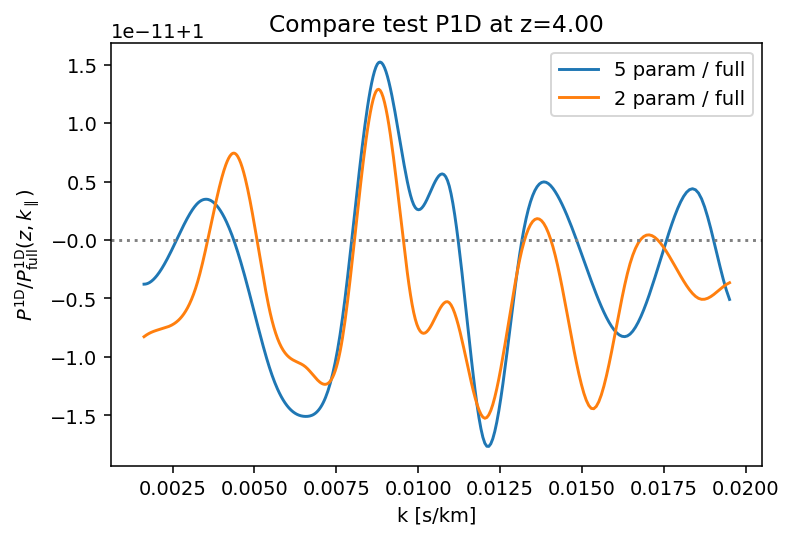

In [43]:
for iz in range(0,len(zs),4):
    z=zs[iz]
    plt.figure()
    plt.plot(k_kms,old_p1d_test[iz]/new_p1d_test[iz],label='5 param / full')
    plt.plot(k_kms,culled_p1d_test[iz]/new_p1d_test[iz],label='2 param / full')
    plt.legend()
    plt.xlabel('k [s/km]')
    plt.ylabel(r'$P^{\rm 1D} / P^{\rm 1D}_{\rm full} (z,k_\parallel)$')
    plt.xlim(min(k_kms)-0.001,max(k_kms)+0.001)
    plt.axhline(y=1,ls=':',color='gray')
    plt.title('Compare test P1D at z={:.2f}'.format(z))

### We get exactly the same predictions and likelihoods from both theories!